# Sentiment analysis with a transformer encoder.

This notebook contains code that demonstrates how to build a transformer encoder from scratch for binary sentiment classification.

In [1]:
import pandas as pd
# Set the device to GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# DATA
DATA = pd.read_csv('data/go_emotions_dataset.csv')
CATEGORIES = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']

TEXT = 'text'
TOTAL_SIZE = len(DATA)
# CONFIGURATION
TRAIN_SIZE = int(TOTAL_SIZE*0.8)
VAL_SIZE = int(TOTAL_SIZE*0.1)
TEST_SIZE = int(TOTAL_SIZE*0.1)

TRAIN_DATA = DATA[:TRAIN_SIZE]
TRAIN_DATA = TRAIN_DATA[TRAIN_DATA['example_very_unclear'] == False]

VAL_DATA = DATA[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]

TEST_DATA = DATA[TRAIN_SIZE+VAL_SIZE:]

print(f"Train size: {len(TRAIN_DATA)}")
print(f"Val size: {len(VAL_DATA)}")
print(f"Test size: {len(TEST_DATA)}")

# MODEL PARAMS
BATCH_SIZE=64
VOCAB_SIZE=10000
SEQUENCE_LENGTH=128
EMBEDDING_DIM=100
D_FF=1024
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=20

Train size: 56041
Val size: 7122
Test size: 7123


In [20]:
import random

### TODO ### SENTENCE AUGMENTATION ###
def augment_text(original_text, num_variations=3):
    # Split the original text into words
    words = original_text.split()

    # Generate variations
    augmented_phrases = []
    for _ in range(num_variations):
        variation = list(words)  # Create a copy of the original words
        for i in range(len(variation)):
            # Randomly replace some words with synonyms or similar words
            if random.random() < 0.2:  # Adjust the probability as needed
                # Replace with a synonym (you can use WordNet or other resources)
                # Example: variation[i] = get_synonym(variation[i])
                pass
            # Add some noise (e.g., typos, extra words, or missing words)
            elif random.random() < 0.1:
                # Example: variation.insert(i, "extra_word")
                # Example: variation.pop(i)
                pass

        # Join the words back into a phrase
        augmented_phrases.append(" ".join(variation))

    return augmented_phrases

# Example usage
original_phrase = "I love deep learning."
augmented_phrases = augment_text(original_phrase)
for phrase in augmented_phrases:
    print(phrase)


I love deep learning.
I love deep learning.
I love deep learning.


## 1. Data loading.

In [2]:
def load_and_split_data(data):
    text = data[TEXT].values
    label = data[CATEGORIES].values
    return text, label

# Load the data
train_data, train_labels = load_and_split_data(TRAIN_DATA)
val_data, val_labels = load_and_split_data(VAL_DATA)
test_data, test_labels = load_and_split_data(TEST_DATA)


train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))



## 2. Data preprocessing.

In [3]:

def standardization(input_data):
    input_data = tf.strings.lower(input_data)
    input_data = tf.strings.regex_replace(input_data, r'\d+', '')
    input_data = tf.strings.regex_replace(input_data, r'[^\w\s]', '')
    input_data = tf.strings.strip(input_data)
    return input_data






In [4]:
vectorize_layer=tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=SEQUENCE_LENGTH
)


In [5]:
training_dataset = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(training_dataset)


In [6]:
def vectorizer(review,label):
    review =  vectorize_layer(review)
    if len(review)<SEQUENCE_LENGTH:
        review = tf.pad(review, [[0,SEQUENCE_LENGTH-len(review)]])
    return review,label

In [7]:
import pickle
with open('models/vectorize_layer.h5', 'wb') as f:
    pickle.dump({'weights':vectorize_layer.get_weights(), 'config': vectorize_layer.get_config()}, f)

In [8]:
train_dataset=train_dataset.map(vectorizer)
val_dataset=val_dataset.map(vectorizer)
test_dataset=test_dataset.map(vectorizer)



In [9]:
train_dataset=train_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

## 3. Data modelling
### 3.1. Embedding layer.

In [10]:
import numpy as np
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [11]:
class Embeddings(tf.keras.layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=tf.keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
      config = super().get_config()
      config.update({
        "sequence_length": self.sequence_length,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim,
      })
      return config

### 3.2 Encoder layer.

In [12]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="elu"),tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask
      )

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
      config = super().get_config()
      config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
      })
      return config

### 3. Final model.

In [13]:
encoder_input=tf.keras.layers.Input(shape=(None,), dtype="int64", name="input")

x = Embeddings(SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(encoder_input)

for _ in range(NUM_LAYERS):
  
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)

x = tf.keras.layers.Flatten()(x)
output=tf.keras.layers.Dense(len(CATEGORIES), activation="sigmoid")(x)

transformer = tf.keras.Model(
    encoder_input, output, name="transformer"
)
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
embeddings (Embeddings)      (None, 128, 100)          1000000   
_________________________________________________________________
transformer_encoder (Transfo (None, 128, 100)          528824    
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                345627    
Total params: 1,874,451
Trainable params: 1,874,451
Non-trainable params: 0
_________________________________________________________________


In [14]:
checkpoint_filepath = 'models/transformer.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8)

In [15]:

transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              metrics=['accuracy'])



### 4. Model training.

In [16]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, reduce_lr])

Epoch 1/20
875/875 [==============================] - 42s 41ms/step - loss: 0.1492 - accuracy: 0.1493 - val_loss: 0.1447 - val_accuracy: 0.1920
Epoch 2/20
875/875 [==============================] - 35s 40ms/step - loss: 0.1432 - accuracy: 0.1669 - val_loss: 0.1362 - val_accuracy: 0.2665
Epoch 3/20
875/875 [==============================] - 37s 42ms/step - loss: 0.1303 - accuracy: 0.2104 - val_loss: 0.1267 - val_accuracy: 0.2261
Epoch 4/20
875/875 [==============================] - 36s 41ms/step - loss: 0.1195 - accuracy: 0.2588 - val_loss: 0.1201 - val_accuracy: 0.2724
Epoch 5/20
875/875 [==============================] - 37s 42ms/step - loss: 0.1122 - accuracy: 0.2929 - val_loss: 0.1176 - val_accuracy: 0.2865
Epoch 6/20
875/875 [==============================] - 38s 44ms/step - loss: 0.1064 - accuracy: 0.3190 - val_loss: 0.1166 - val_accuracy: 0.2907
Epoch 7/20
875/875 [==============================] - 37s 42ms/step - loss: 0.1012 - accuracy: 0.3403 - val_loss: 0.1164 - val_accuracy:

### 5. Accuracy evolution.

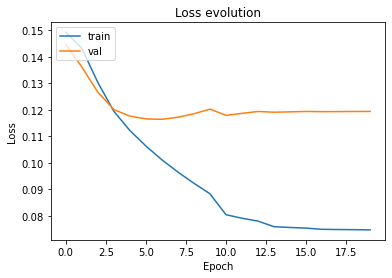

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
evaluation = transformer.evaluate(test_dataset.batch(1))
print("Done")
print(f"Final loss: {evaluation[0]}")
print(f"Final accuracy: {evaluation[1]}")

7123/7123 [==============================] - 41s 5ms/step - loss: 0.1188 - accuracy: 0.2694
Done
Final loss: 0.11884614825248718
Final accuracy: 0.2694089710712433


([<matplotlib.axis.XTick at 0x2ae899c02b0>,
 [Text(0, 0, 'admiration'),
  Text(1, 0, 'amusement'),
  Text(2, 0, 'anger'),
  Text(3, 0, 'annoyance'),
  Text(4, 0, 'approval'),
  Text(5, 0, 'caring'),
  Text(6, 0, 'confusion'),
  Text(7, 0, 'curiosity'),
  Text(8, 0, 'desire'),
  Text(9, 0, 'disappointment'),
  Text(10, 0, 'disapproval'),
  Text(11, 0, 'disgust'),
  Text(12, 0, 'embarrassment'),
  Text(13, 0, 'excitement'),
  Text(14, 0, 'fear'),
  Text(15, 0, 'gratitude'),
  Text(16, 0, 'grief'),
  Text(17, 0, 'joy'),
  Text(18, 0, 'love'),
  Text(19, 0, 'nervousness'),
  Text(20, 0, 'optimism'),
  Text(21, 0, 'pride'),
  Text(22, 0, 'realization'),
  Text(23, 0, 'relief'),
  Text(24, 0, 'remorse'),
  Text(25, 0, 'sadness'),
  Text(26, 0, 'surprise')])

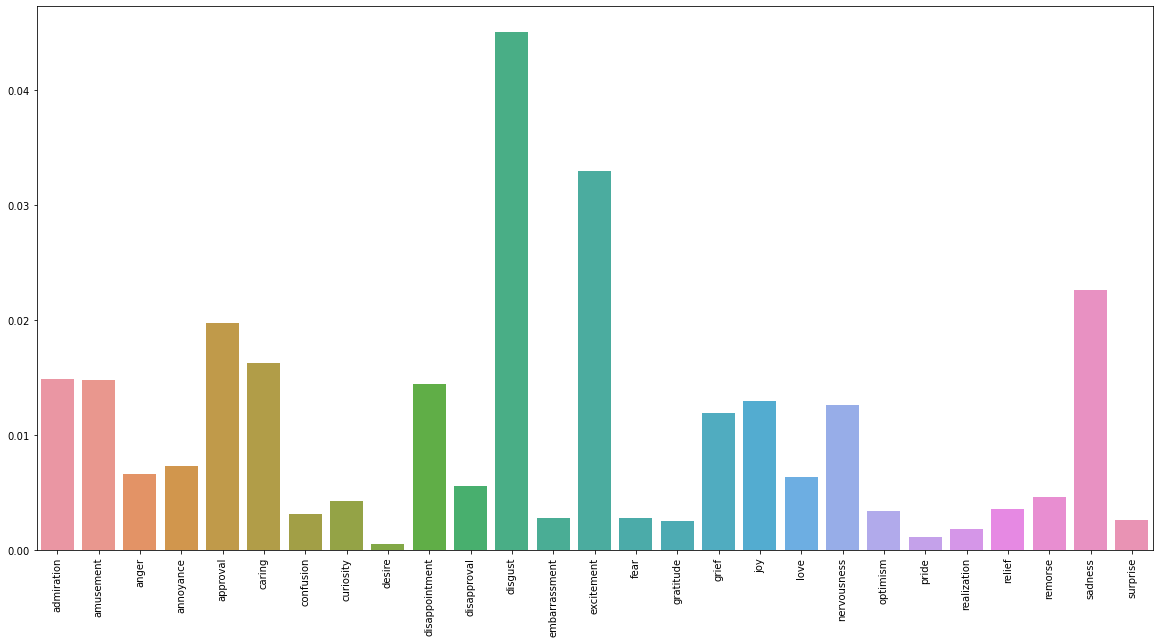

In [19]:
import seaborn as sns
text = "I am happy. I am sad. I am angry. I am disgusted. I am surprised. I am neutral."
text, label = vectorizer(text, [0]*28)
prediction = transformer.predict(text)
plt.figure(figsize=(20,10))
sns.barplot(x=CATEGORIES, y=prediction[0])
plt.xticks(plt.gca().get_xticks(), rotation=90)



